In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from sklearn.metrics import mean_squared_error

In [7]:
# Verifica si tienes una GPU disponible y configura el dispositivo.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)

Dispositivo actual: cuda


In [8]:
# Cargar datos
df = pd.read_pickle('./Datasets/df_ETHUSDT_4h.pickle')
df.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA20,EMA40,EMA60,fastk,fastd,macd_line,signal_line,upper,middle,lower
0,2020-10-18 13:00:00,375.66,376.85,374.81,375.74,41634.6019,57.566743,371.915841,371.948304,372.790333,100.000000,94.322544,-0.199425,-1.094532,378.707663,373.312,367.916337
1,2020-10-18 17:00:00,375.72,378.64,374.98,378.11,45734.8910,61.067141,372.505761,372.248875,372.964749,100.000000,100.000000,0.317210,-0.812184,378.879214,375.254,371.628786
2,2020-10-18 21:00:00,378.12,380.00,372.50,373.00,93611.4211,51.250433,372.552832,372.285515,372.965904,0.000000,66.666667,0.310730,-0.587601,379.026793,375.062,371.097207
3,2020-10-19 01:00:00,372.97,375.72,372.73,375.03,57683.7913,54.387353,372.788752,372.419392,373.033580,31.954903,43.984968,0.464050,-0.377271,378.785173,375.514,372.242827
4,2020-10-19 05:00:00,375.02,377.71,374.28,375.75,63807.0544,55.481546,373.070776,372.581861,373.122643,43.101133,25.018679,0.636320,-0.174553,378.800107,375.526,372.251893


In [9]:
df.columns[1::]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA20', 'EMA40',
       'EMA60', 'fastk', 'fastd', 'macd_line', 'signal_line', 'upper',
       'middle', 'lower'],
      dtype='object')

In [10]:
len(df.columns[1::])

16

***

CUDA

No checkpoint found.
Epoch 0, loss: 0.2274456024169922
Mean Squared Error (MSE): 0.08479808270931244
Epoch 100, loss: 0.0008462747209705412
Mean Squared Error (MSE): 0.00021251507860142738
Epoch 200, loss: 0.00036327954148873687
Mean Squared Error (MSE): 5.602277087746188e-05
Epoch 300, loss: 0.0002853880578186363
Mean Squared Error (MSE): 6.913179822731763e-05
Epoch 400, loss: 0.00023409374989569187
Mean Squared Error (MSE): 7.641466072527692e-05
Epoch 500, loss: 0.00020428936113603413
Mean Squared Error (MSE): 7.682386785745621e-05
Epoch 600, loss: 0.00019111658912152052
Mean Squared Error (MSE): 7.559075311291963e-05
Epoch 700, loss: 0.00018769553571473807
Mean Squared Error (MSE): 6.997723539825529e-05
Epoch 800, loss: 0.00017095962539315224
Mean Squared Error (MSE): 6.855449464637786e-05
Epoch 900, loss: 0.0001662150170886889
Mean Squared Error (MSE): 6.545751966768876e-05
Epoch 1000, loss: 0.000158476919750683
Mean Squared Error (MSE): 6.038823630660772e-05
Epoch 1100, loss: 0.00

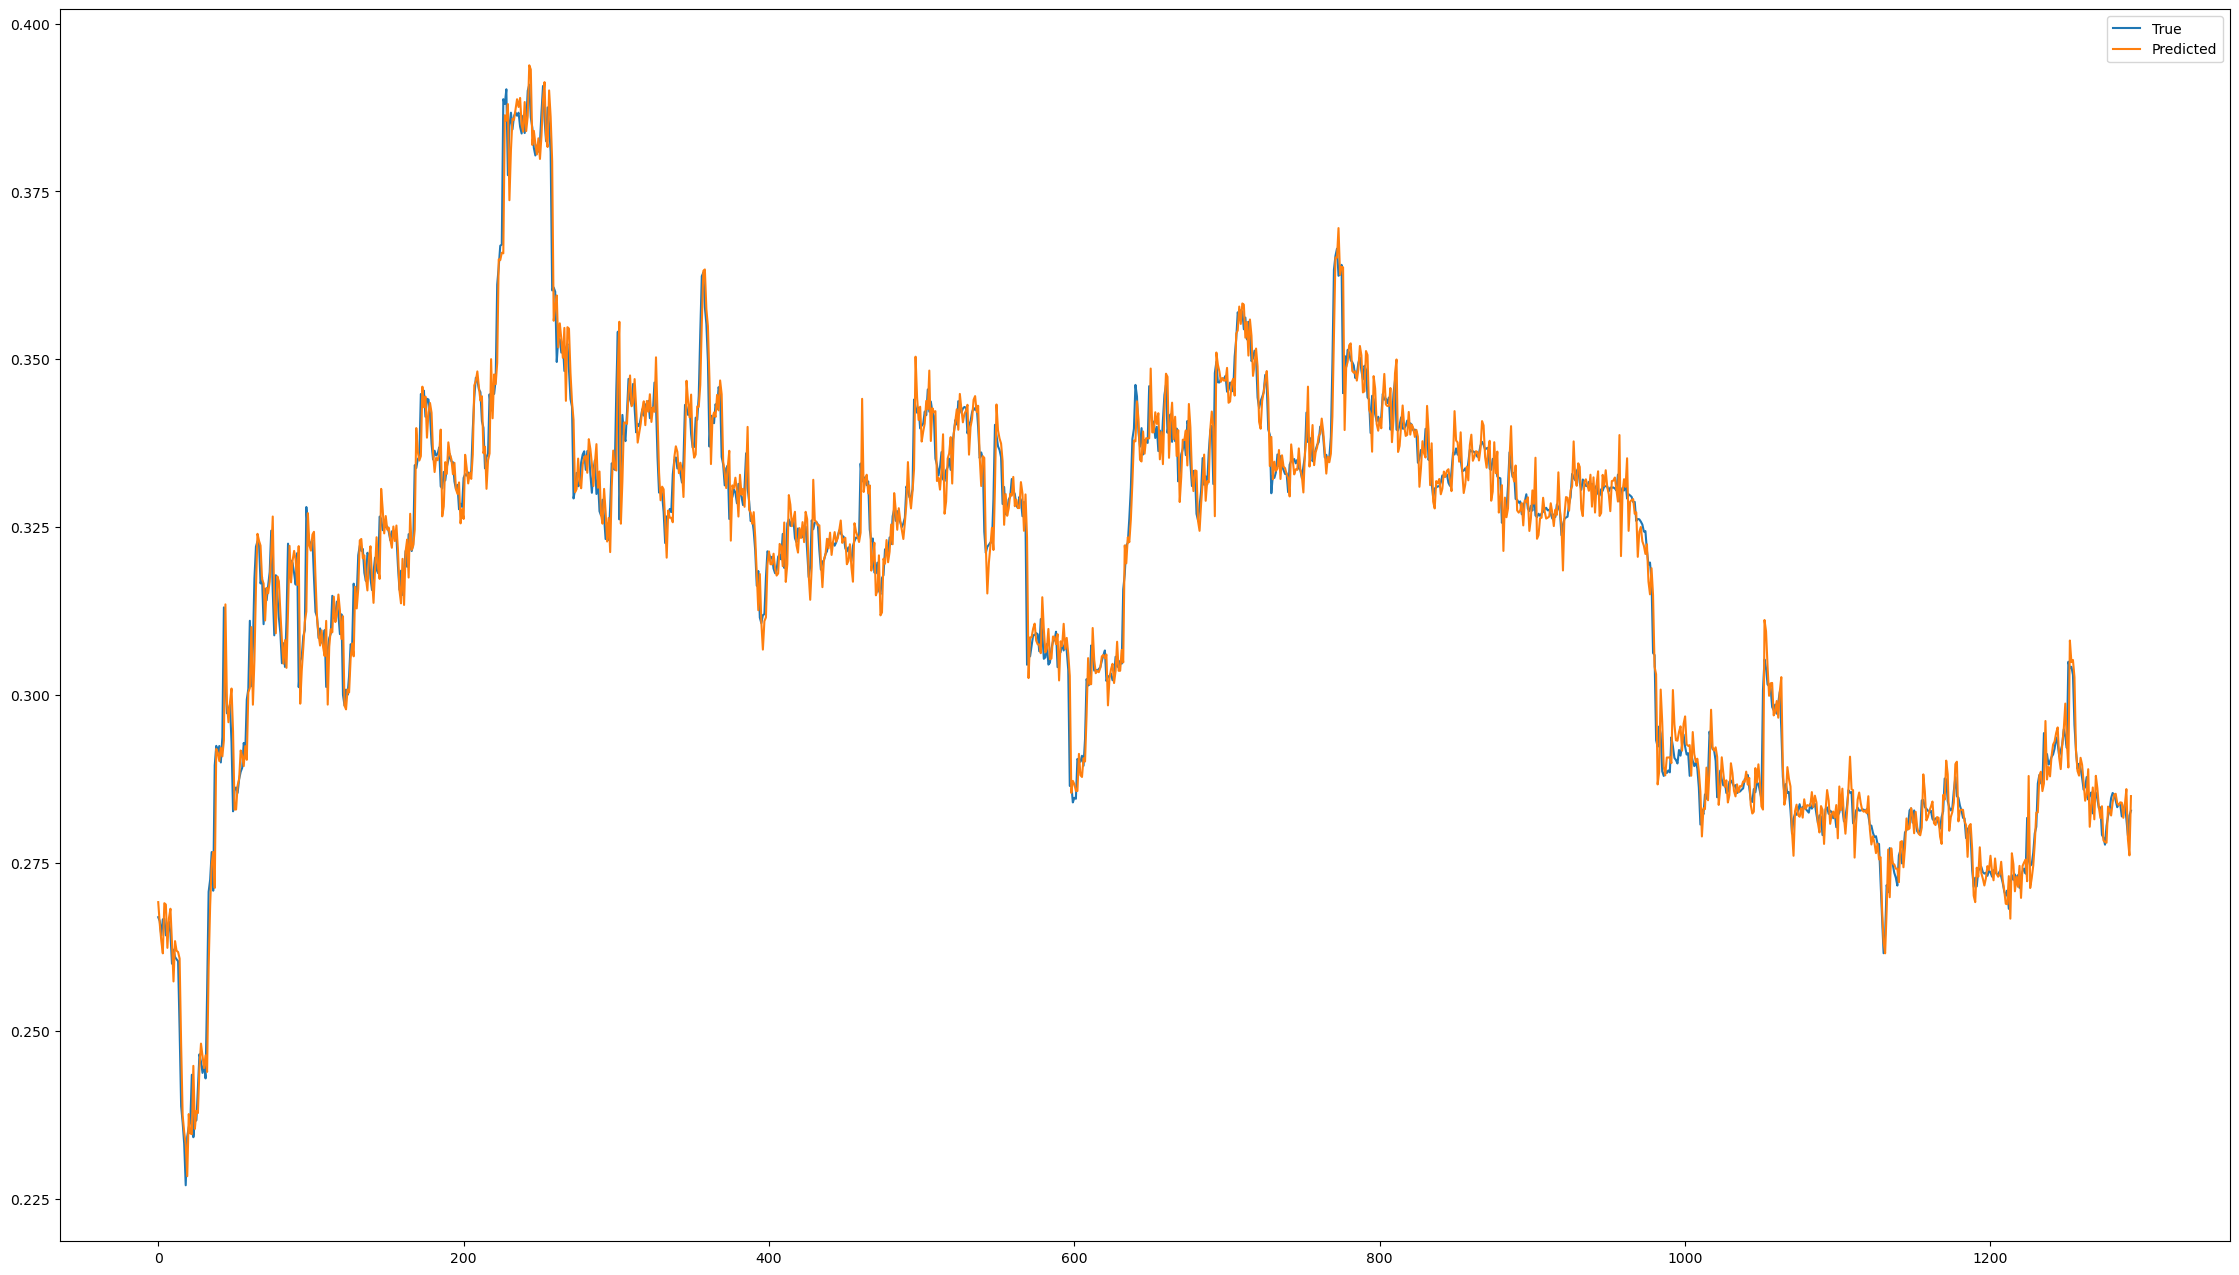

In [21]:
# Parámetros
seq_length = 10  # Longitud de la secuencia
train_size = 0.8  # Porcentaje de datos para entrenamiento
inputs = len(df.columns[1::])  # Número de características de entrada

# Función para preparar los datos
def prepare_data(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length, 3]  # Se asume que la columna 3 es 'Close'
        sequences.append(seq)
        target.append(label)

    # Convertir las listas a numpy arrays y luego a tensores de PyTorch
    sequences = np.array(sequences)
    target = np.array(target)
    return torch.tensor(sequences, dtype=torch.float32).cuda(), torch.tensor(target, dtype=torch.float32).view(-1, 1).cuda()


loss_function = nn.MSELoss()

# Normalizar los datos
data = df[df.columns[1::]].values
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Dividir los datos en entrenamiento y evaluación
train_size = int(len(data) * train_size)
train_data = data[:train_size]
eval_data = data[train_size:]

# Preparar los datos
train_sequences, train_target = prepare_data(train_data, seq_length)
eval_sequences, eval_target = prepare_data(eval_data, seq_length)

# Mover datos de entrenamiento y evaluación a la GPU
train_sequences = train_sequences.cuda()
train_target = train_target.cuda()
eval_sequences = eval_sequences.cuda()
eval_target = eval_target.cuda()

# Modificar la definición del modelo LSTM para ser más complejo
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Capa LSTM con múltiples capas apiladas
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True).cuda()

        # Capa completamente conectada
        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

    def forward(self, input_seq):
        # Inicializar las celdas ocultas
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()

        # Propagación hacia adelante
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Inicializar el modelo con más capas LSTM
model = ComplexLSTM(input_size=inputs, hidden_layer_size=100, output_size=1, num_layers=4).to(device)

# Inicializar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


lista_loss = []
lista_mse = []
# Ruta para guardar los checkpoints
checkpoint_path = 'checkpoints/model_checkpoint.pth'

# Función para cargar un checkpoint si existe
def load_checkpoint():
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        lista_loss.extend(checkpoint['lista_loss'])
        print(f"Loaded checkpoint from epoch {epoch}")
        return epoch
    else:
        print("No checkpoint found.")
        return 0

# Cargar un posible checkpoint
start_epoch = load_checkpoint()

epochs = 13100

# Continuar entrenamiento desde el último epoch
for i in range(start_epoch, epochs+1):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(train_sequences)

    loss = loss_function(y_pred, train_target)
    loss.backward()
    optimizer.step()
    lista_loss.append(loss.item())

    if i % 100 == 0:
        print(f'Epoch {i}, loss: {loss.item()}')
        # Evaluación del modelo
        model.eval()
        eval_predictions = []
        with torch.no_grad():
            eval_predictions = model(eval_sequences)
        mse = mean_squared_error(eval_target.cpu(), eval_predictions.cpu())
        lista_mse.append(mse.item())
        print(f'Mean Squared Error (MSE): {mse}')
        

    # Guardar checkpoint cada 1000 epochs
    if i % 1000 == 0  and i != 0:
        checkpoint = {
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lista_loss': lista_loss
        }
        torch.save(checkpoint, checkpoint_path)
        print('checkpoint save')

# Evaluación del modelo
model.eval()
eval_predictions = []
with torch.no_grad():
    eval_predictions = model(eval_sequences)

# Graficar los resultados
plt.figure(figsize=(28, 16))
plt.plot(eval_target.cpu(), label='True')
plt.plot(eval_predictions.cpu(), label='Predicted')
plt.legend()
plt.show()


In [7]:
len(lista_mse)

51

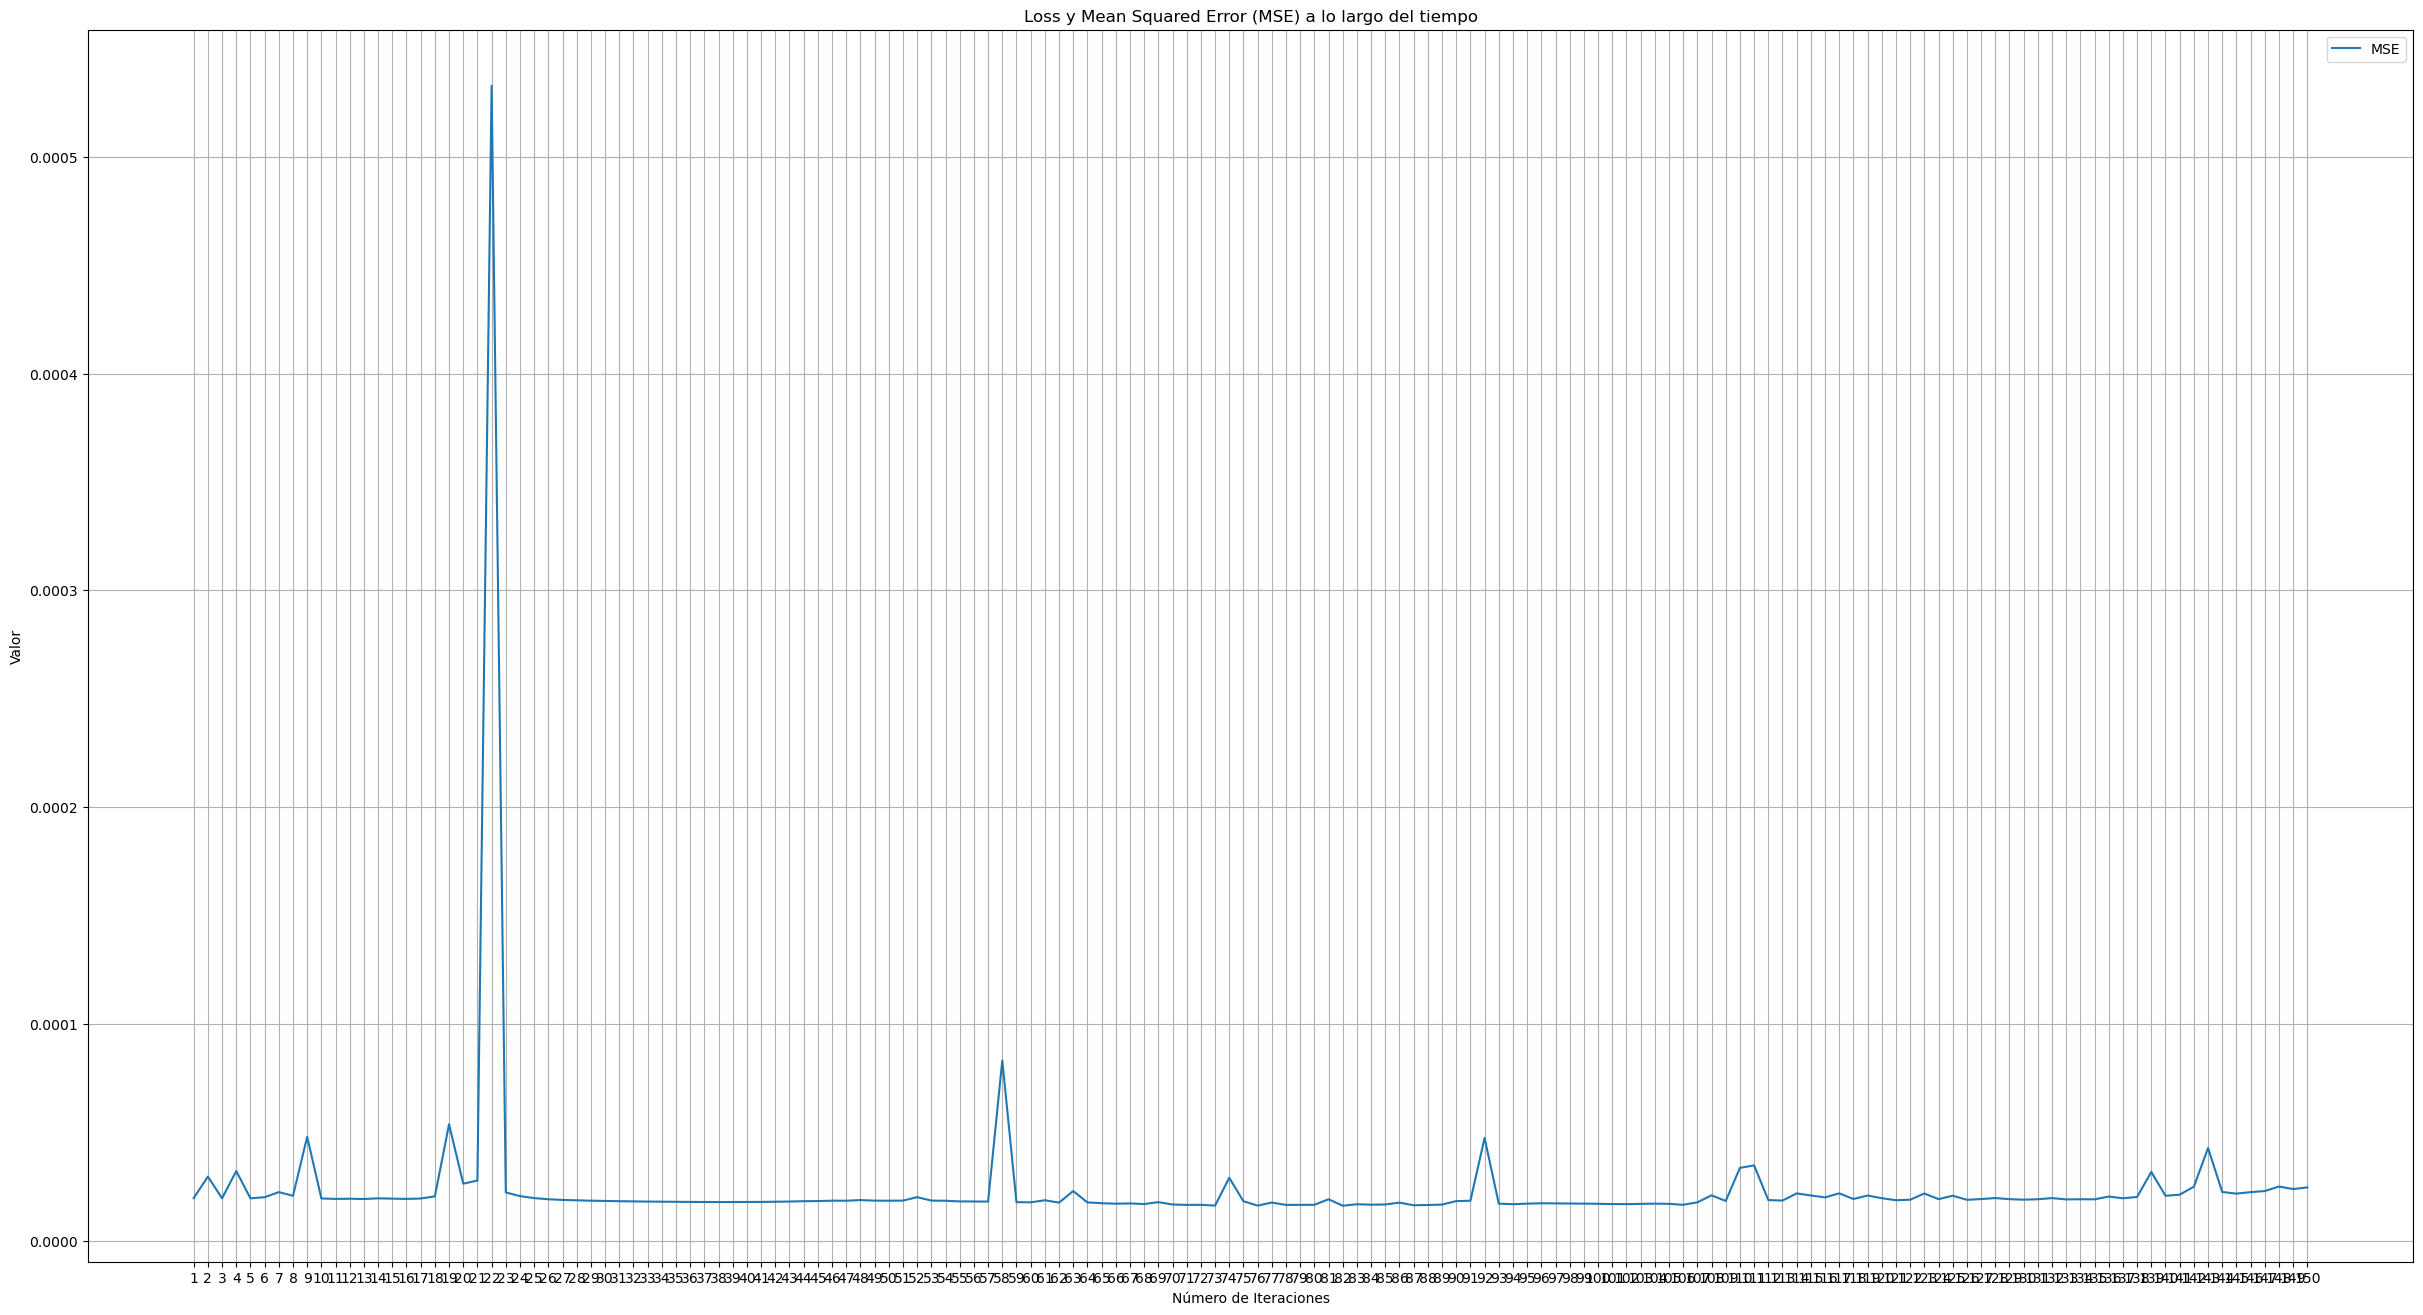

In [20]:
#temp_lista_loss = lista_loss[0:2000]
temp_lista_mse = lista_mse[50:200]

# Crear una lista de índices para representar el tamaño de la lista
indices = list(range(1, len(temp_lista_mse) + 1))

# Establecer el tamaño de la figura
plt.figure(figsize=(30, 16))

# Trazar el gráfico
#plt.plot(indices, lista_loss, label='Loss')
plt.plot(indices, temp_lista_mse, label='MSE')

# Etiquetas y título
plt.xlabel('Número de Iteraciones')
plt.ylabel('Valor')
plt.title('Loss y Mean Squared Error (MSE) a lo largo del tiempo')
plt.legend()
plt.xticks(indices)
plt.grid(True)
plt.show()

In [13]:
lista_mse[0]

0.09892484545707703

In [14]:
type(lista_mse[0])

float

In [23]:
lista_mse.index(min(lista_mse))

131

In [90]:
mean_list = []
max = 1
for epoch in lista_loss:
    temp = lista_loss[:max]
    temp = sum(temp) / len(temp)
    mean_list.append(temp)
    max += 1

mean_list.index(min(mean_list))

99999

In [97]:
min(mean_list)

3.590393431873292e-05

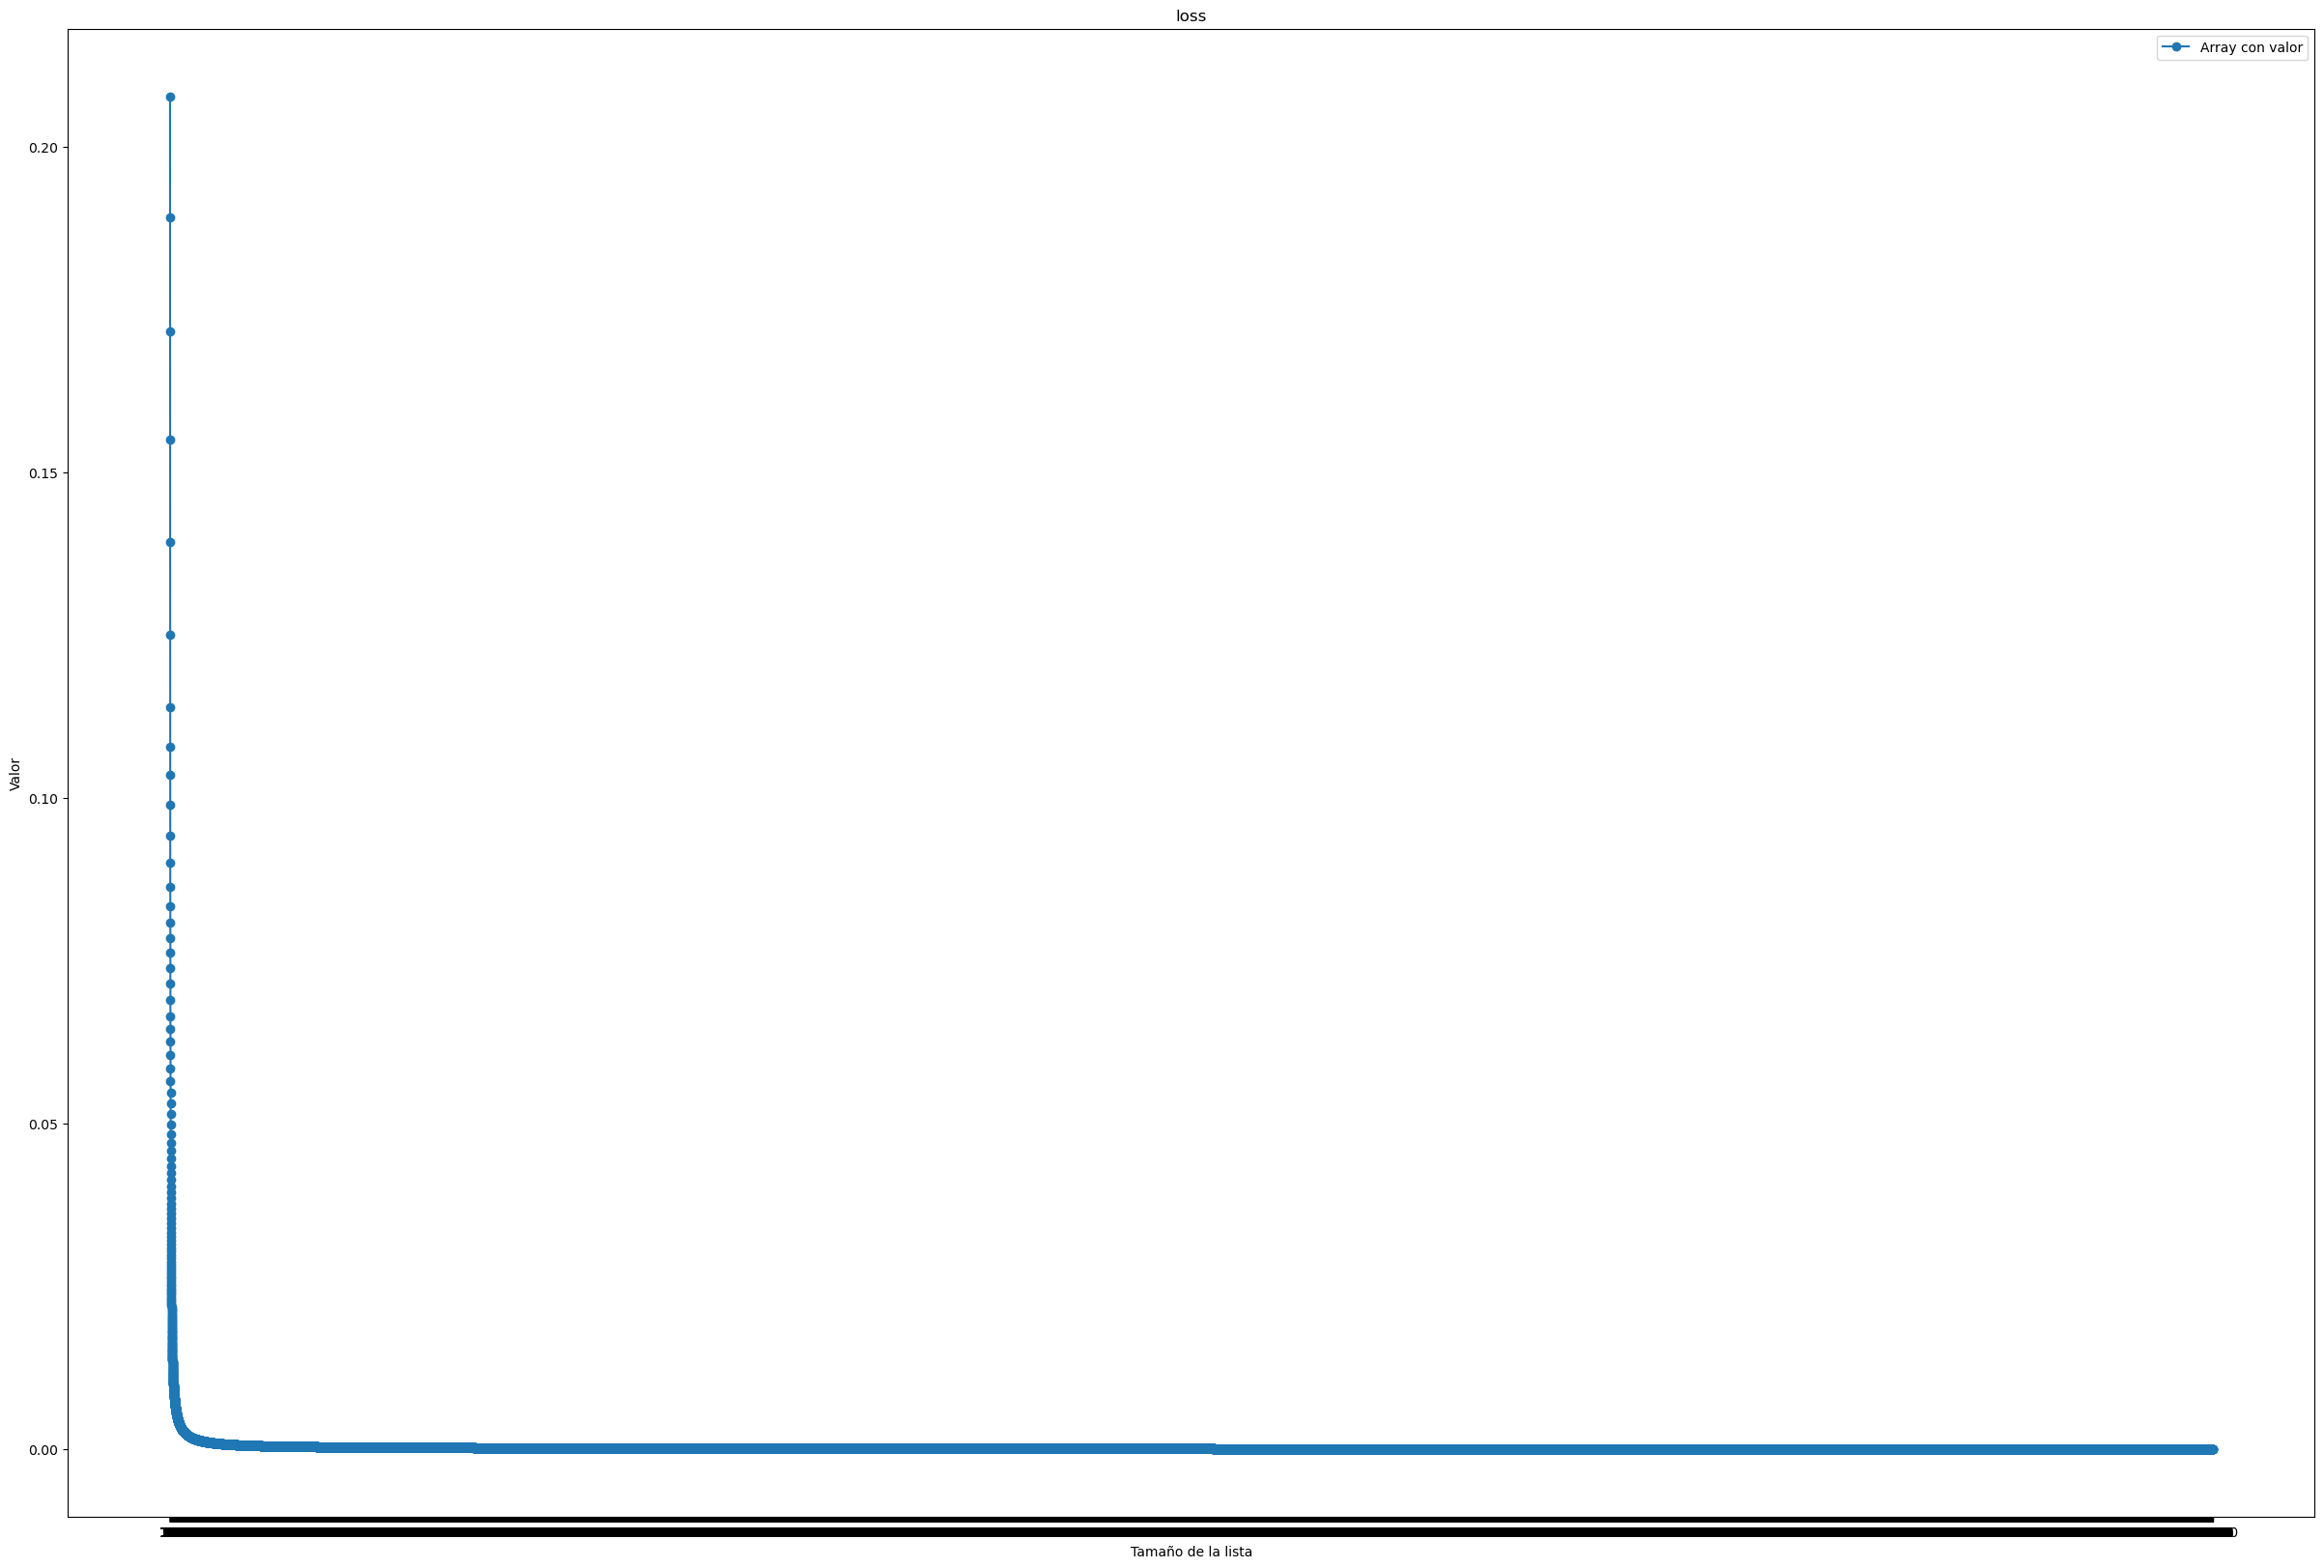

In [92]:
# Crear una lista de índices para representar el tamaño de la lista
indices = list(range(1, len(mean_list) + 1))

# Establecer el tamaño de la figura
plt.figure(figsize=(30, 20))  # Ancho: 10 pulgadas, Alto: 6 pulgadas

# Trazar el gráfico
plt.plot(indices, mean_list, 'o-', label='Array con valor')

# Etiquetas y título
plt.xlabel('Tamaño de la lista')
plt.ylabel('Valor')
plt.title('loss')
plt.legend()
plt.xticks(indices)
plt.show()

***

In [133]:
load_checkpoint()

Loaded checkpoint from epoch 491114


491114

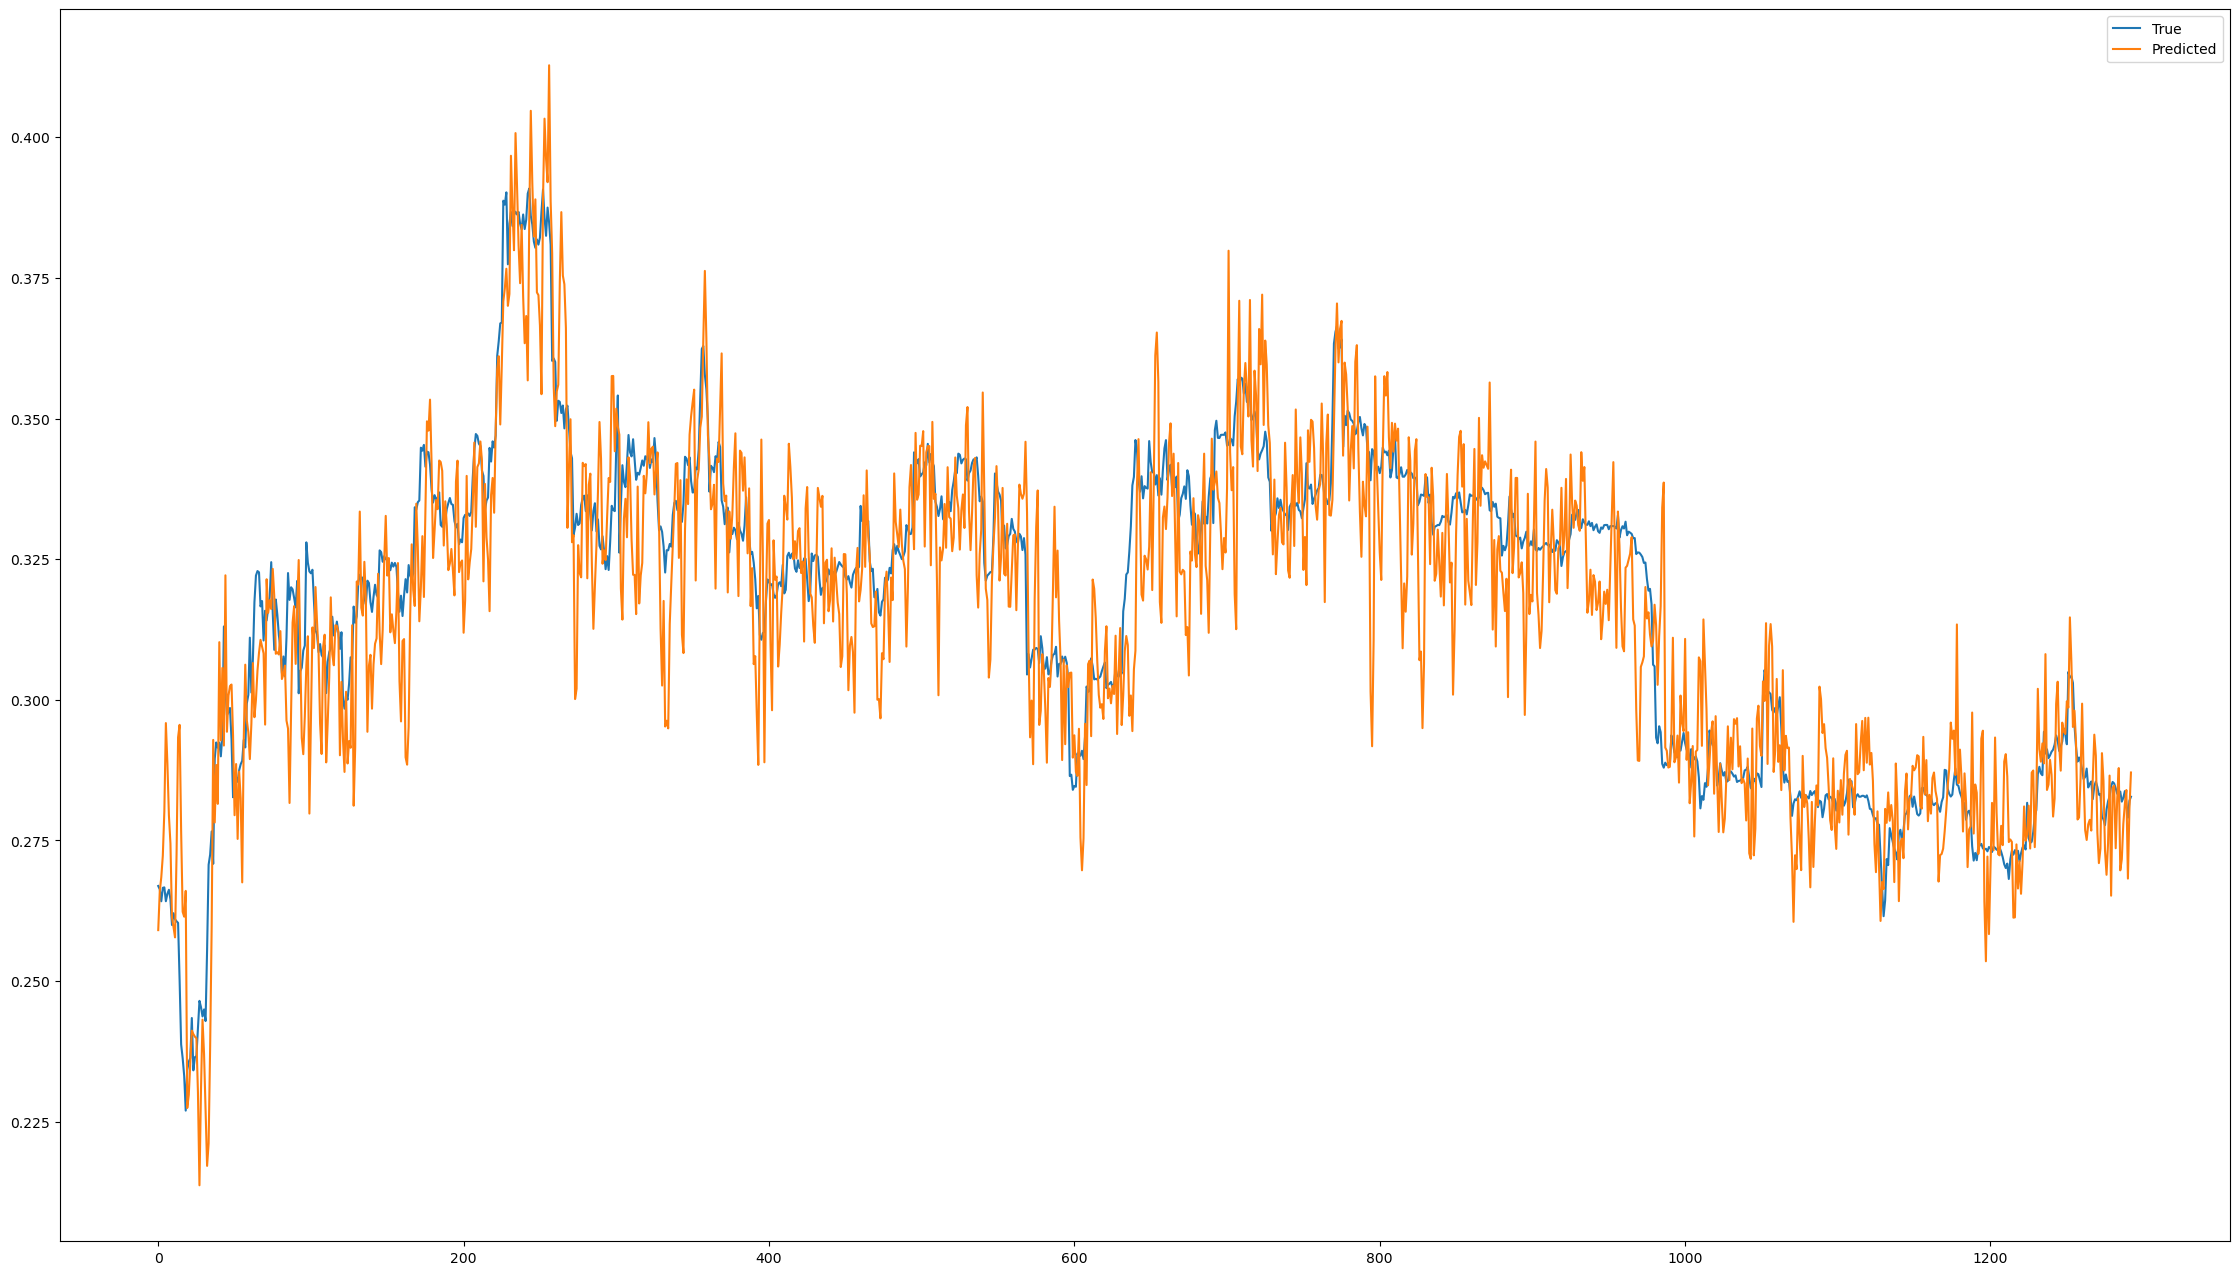

In [134]:
# Evaluación del modelo
model.eval()
eval_predictions = []
with torch.no_grad():
    eval_predictions = model(eval_sequences)

# Graficar los resultados
plt.figure(figsize=(28, 16))
plt.plot(eval_target.cpu(), label='True')
plt.plot(eval_predictions.cpu(), label='Predicted')
plt.legend()
plt.show()

***

In [11]:
# Parámetros
seq_length = 10  # Longitud de la secuencia
train_size = 0.8  # Porcentaje de datos para entrenamiento
inputs = len(df.columns[1::])  # Número de características de entrada

# Función para preparar los datos
def prepare_data(data, seq_length):
    sequences = []
    target_high = []
    target_low = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label_high = data[i+seq_length, 1]  # Columna 'High'
        label_low = data[i+seq_length, 2]  # Columna 'Low'
        sequences.append(seq)
        target_high.append(label_high)
        target_low.append(label_low)

    # Convertir las listas a numpy arrays y luego a tensores de PyTorch
    sequences = np.array(sequences)
    target_high = np.array(target_high)
    target_low = np.array(target_low)
    return (
        torch.tensor(sequences, dtype=torch.float32).cuda(),
        (torch.tensor(target_high, dtype=torch.float32).view(-1, 1).cuda(), 
         torch.tensor(target_low, dtype=torch.float32).view(-1, 1).cuda())
    )

loss_function = nn.MSELoss()

# Normalizar los datos
data = df[df.columns[1::]].values
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Dividir los datos en entrenamiento y evaluación
train_size = int(len(data) * train_size)
train_data = data[:train_size]
eval_data = data[train_size:]

# Preparar los datos
train_sequences, (train_target_high, train_target_low) = prepare_data(train_data, seq_length)
eval_sequences, (eval_target_high, eval_target_low) = prepare_data(eval_data, seq_length)

# Mover datos de entrenamiento y evaluación a la GPU
train_sequences = train_sequences.cuda()
train_target_high = train_target_high.cuda()
train_target_low = train_target_low.cuda()
eval_sequences = eval_sequences.cuda()
eval_target_high = eval_target_high.cuda()
eval_target_low = eval_target_low.cuda()

# Modificar la definición del modelo LSTM para predecir 'High' y 'Low'
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Capa LSTM con múltiples capas apiladas
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True).cuda()

        # Capa completamente conectada para predecir 'High'
        self.linear_high = nn.Linear(hidden_layer_size, output_size).cuda()

        # Capa completamente conectada para predecir 'Low'
        self.linear_low = nn.Linear(hidden_layer_size, output_size).cuda()

    def forward(self, input_seq):
        # Inicializar las celdas ocultas
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()

        # Propagación hacia adelante
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions_high = self.linear_high(lstm_out[:, -1, :])
        predictions_low = self.linear_low(lstm_out[:, -1, :])
        return predictions_high, predictions_low

# Inicializar el modelo con más capas LSTM
model = ComplexLSTM(input_size=inputs, hidden_layer_size=100, output_size=1, num_layers=4).to(device)

# Inicializar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Resto del código
# ...

lista_loss = []
lista_mse = []
# Ruta para guardar los checkpoints
checkpoint_path = 'checkpoints/model_checkpoint.pth'

# Función para cargar un checkpoint si existe
def load_checkpoint():
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        lista_loss.extend(checkpoint['lista_loss'])
        print(f"Loaded checkpoint from epoch {epoch}")
        return epoch
    else:
        print("No checkpoint found.")
        return 0

# Cargar un posible checkpoint
start_epoch = load_checkpoint()

epochs = 13100

# Continuar entrenamiento desde el último epoch
for i in range(start_epoch, epochs+1):
    model.train()
    optimizer.zero_grad()
    
    y_pred_high, y_pred_low = model(train_sequences)
    
    loss_high = loss_function(y_pred_high, train_target_high)
    loss_low = loss_function(y_pred_low, train_target_low)
    loss = loss_high + loss_low  # Suma de las pérdidas para 'High' y 'Low'
    loss.backward()
    optimizer.step()
    lista_loss.append(loss.item())

    if i % 100 == 0:
        print(f'Epoch {i}, loss: {loss.item()}')
        # Evaluación del modelo
        model.eval()
        eval_predictions_high, eval_predictions_low = model(eval_sequences)
        mse_high = mean_squared_error(eval_target_high.cpu(), eval_predictions_high.cpu())
        mse_low = mean_squared_error(eval_target_low.cpu(), eval_predictions_low.cpu())
        mse = mse_high + mse_low  # Suma de los errores cuadráticos para 'High' y 'Low'
        lista_mse.append(mse)
        print(f'Mean Squared Error (MSE): {mse}')
        
    # Guardar checkpoint cada 1000 epochs
    if i % 1000 == 0 and i != 0:
        checkpoint = {
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lista_loss': lista_loss
        }
        torch.save(checkpoint, checkpoint_path)
        print('Checkpoint saved')

# Evaluación del modelo
model.eval()
eval_predictions_high, eval_predictions_low = model(eval_sequences)

# Graficar los resultados
plt.figure(figsize=(28, 16))
plt.plot(eval_target_high.cpu(), label='True High')
plt.plot(eval_predictions_high.cpu(), label='Predicted High')
plt.plot(eval_target_low.cpu(), label='True Low')
plt.plot(eval_predictions_low.cpu(), label='Predicted Low')
plt.legend()
plt


No checkpoint found.
Epoch 0, loss: 0.4630107283592224


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.